### Sales Forecast

**Motivation! What's the context?**
- In 2017 Olist started to forecast its monthly sales based on the average revenue from 3 months before. But now the company  wants to be able to predict future sales more accurately.

**Why?**
- To efficiently allocate resources for future projects, growth and manage its cash flow. 

**Who are the stakeholders?**
- The financial sector will use the forecast to the set operating budgets and to project cash flows.
- And the marketing team, who will have the opportunity to schedule promotions if it appears sales <br>
will be weak and will be able to better allocate budget among other marketing activities.

**What is the deliverable?**
- A dashboard with the information about the forecast.


> **ps: We will use the data to forecast the second quarter of 2018 and the third quarter will be our "production data".**

## Agenda

[Cycles Notes](#Cycles-Notes)<br>

[0.0 Loading Data](#0.0-Loading-Data)<br>
&nbsp;[0.1 Filter Features](#0.1-Filter-Features)<br>

[1.0 Data Preparation/Transformation](#1.0-Data-Preparation/Transformation)<br>
&nbsp;[1.1 Rescaling](#1.1-Rescaling)<br>
&nbsp;&nbsp;[1.1.1. Min-Max Scaler](#1.1.1.-Min-Max-Scaler)<br>
&nbsp;&nbsp;[1.1.1. normalize](#1.1.1.-normalize)<br>
&nbsp;[1.2 Feature Encoding](#1.2-Feature-Encoding)<br>
&nbsp;[1.3 Response Variable Transformation](#1.3-Response-Variable-Transformation)<br>
&nbsp;[1.4 Nature Transformation (dates)](#1.4-Nature-Transformation-(dates))<br>

[2.0 Baseline Models](#2.0-Baseline-Models)<br>
&nbsp;[2.1 Training Test Split](#2.1-Training-Test-Split)<br>
&nbsp;&nbsp;[2.1.2 RandomForestRegressor](#2.1.2-RandomForestRegressor)<br>
&nbsp;&nbsp;[2.1.3 LinearRegression](#2.1.3-LinearRegression)<br>

[3.0 Features Importances](#3.0-Features-Importances)<br>
&nbsp;[3.1 Random Forest Importance](#3.1-Random-Forest-Importance)<br>
&nbsp;[3.2 Linear Regression Importance](#3.2-Linear-Regression-Importance)<br>


# Cycles Notes

**1st - Really Good Results! Overfitting? Probably.**

On average, our predictions are 0.8% above or below the real value. <br>
Which means an error of about R$ 7241.27

        freight_percentage_from_price with a importance of 72%. Let's remove it now.
        As well as freight_value, since we don't have this information at "prediction time".

**2nd - Bad Bad**

On average, our predictions are 29.79% above or below the real value. <br>
Which means an error of about R$ 314161.29

        I'll try to normalize the data instead of standardize

**3rd - Still Bad**

On average, our predictions are 29.49% above or below the real value. <br>
Which means an error of about R$ 310956.35


In [1]:
import os 
import pandas as pd
import numpy as np 

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
# Settings
__file__ = "1.0-pr-sales-prediction-eda"
THIS_DIR = os.path.dirname(os.path.abspath(__file__))
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
DATA_DIR = os.path.join(os.path.join(BASE_DIR, 'data'))

In [3]:
def evaluation(y_true, y_pred, show_results=True):
    mae = mean_absolute_error(y_true, y_pred).round(2)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    if show_results:
        print(f'''On average, our predictions are {mape.round(2)}% above or below the real value.''')
        print(f'''Which means an error of about R$ {mae}''')
    return mae, mape

## 0.0 Loading Data

In [4]:
data_frame_to_process = pd.read_pickle(os.path.join(os.path.join(DATA_DIR, "sales_forecast_data"), "ml_data_to_preprocess.pkl"))
data_frame_to_process['revenue'] = data_frame_to_process['freight_value'] + data_frame_to_process['price']

df_evaluate = data_frame_to_process.copy()
pd.DataFrame(df_evaluate.groupby([df_evaluate['order_purchase_timestamp'].dt.year, df_evaluate['order_purchase_timestamp'].dt.month])['revenue'].sum())

revenue
order_purchase_timestamp order_purchase_timestamp            
2017                     1                          127367.44
                         2                          269399.65
                         3                          413517.85
                         4                          390205.37
                         5                          564882.30
                         6                          487400.36
                         7                          564067.13
                         8                          643593.37
                         9                          697148.71
                         10                         749240.68
                         11                        1149233.20
                         12                         841078.16
2018                     1                         1076273.40
                         2                          963208.29
                         3                         1117526.68
                         4                         1130099.01
                         5                         1126620.93
                         6                         1009037.40
                         7                         1024797.19
                         8                          982649.62

In [5]:
mask = (data_frame_to_process['order_purchase_timestamp'] < '2018-4-1')
x_train_index = data_frame_to_process.loc[mask].drop(columns=['revenue']).index

mask = (data_frame_to_process['order_purchase_timestamp'] >= '2018-4-1')
x_test_index = data_frame_to_process.loc[mask].drop(columns=['revenue']).index

### 0.1 Filter Features

    Dropping data we don't have access at prediction time, and some correlated columns.

In [6]:
to_drop = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at',
           'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date',
           'customer_unique_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 
           'geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state', 'price',
           'freight_percentage_from_price', 'freight_value']
data_frame_to_process.drop(columns=to_drop, inplace=True)

## 1.0 Data Preparation/Transformation

In [13]:
data_frame = data_frame_to_process.copy()

### 1.1 Rescaling
 
#### 1.1.1. Min-Max Scaler

In [11]:
# columns = data_frame.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).drop(columns=['revenue']).columns
# min_max_scaler = MinMaxScaler()

# for column in columns:
#     min_max_scaler = MinMaxScaler()
#     data_frame[column] = min_max_scaler.fit_transform(data_frame[[column]].values)

#### 1.1.1. normalize

In [14]:
from sklearn import preprocessing
columns = data_frame.select_dtypes(include=['int64', 'float64']).drop(columns=['revenue']).columns
for column in columns:
    data_frame[column] = preprocessing.normalize([data_frame[column]])[0]

### 1.2 Feature Encoding

In [15]:
columns = data_frame.select_dtypes(exclude=['int32', 'int64', 'float32', 'float64', 'bool']).columns

for column in columns:
    label_encoder = LabelEncoder()
    data_frame[column] = label_encoder.fit_transform( data_frame[column] )

In [16]:
for column in columns:
    min_max_scaler = MinMaxScaler()
    data_frame[column] = min_max_scaler.fit_transform(data_frame[[column]].values)

### 1.3 Response Variable Transformation

In [17]:
data_frame['revenue'] =  np.log1p(data_frame['revenue'])

### 1.4 Nature Transformation (dates)

In [19]:
data_frame['purchase_timestamp_month_sin'] = data_frame['purchase_timestamp_month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
data_frame['purchase_timestamp_month_cos'] = data_frame['purchase_timestamp_month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

data_frame['estimated_delivery_date_month_sin'] = data_frame['estimated_delivery_date_month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
data_frame['estimated_delivery_date_month_cos'] = data_frame['estimated_delivery_date_month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

data_frame['purchase_timestamp_day_sin'] = data_frame['purchase_timestamp_day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
data_frame['purchase_timestamp_day_cos'] = data_frame['purchase_timestamp_day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )


data_frame['purchase_timestamp_weekofyear_sin'] = data_frame['purchase_timestamp_weekofyear'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
data_frame['purchase_timestamp_weekofyear_cos'] = data_frame['purchase_timestamp_weekofyear'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

data_frame['estimated_delivery_date_weekofyear_sin'] = data_frame['estimated_delivery_date_weekofyear'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
data_frame['estimated_delivery_date_weekofyear_cos'] = data_frame['estimated_delivery_date_weekofyear'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [20]:
data_frame.drop(columns=['purchase_timestamp_month','estimated_delivery_date_month','purchase_timestamp_day', 
                         'purchase_timestamp_weekofyear','estimated_delivery_date_weekofyear'], inplace=True)

## 2.0 Baseline Models

In [21]:
df = data_frame.copy()

### 2.1 Training Test Split

In [22]:
x_train = df.loc[x_train_index].drop(columns=['revenue'])
y_train = df.loc[x_train_index, 'revenue']

x_test = df.loc[x_test_index].drop(columns=['revenue'])
y_test = df.loc[x_test_index, 'revenue']

#### 2.1.2 RandomForestRegressor

**Individual Prices**

1st cycle:

    On average, our predictions are 71.35% above or below the real value.
    Which means an error of about R$ 86.51
    
2nd cycle:

    On average, our predictions are 71.86% above or below the real value.
    Which means an error of about R$ 86.59

In [27]:
rf = RandomForestRegressor(min_samples_leaf=9)
rf.fit(x_train, y_train)

rf_predictions = rf.predict(x_test)
evaluation(np.expm1(y_test), np.expm1(rf_predictions))

On average, our predictions are 71.86% above or below the real value.
Which means an error of about R$ 86.59


(86.59, 71.85660562210293)

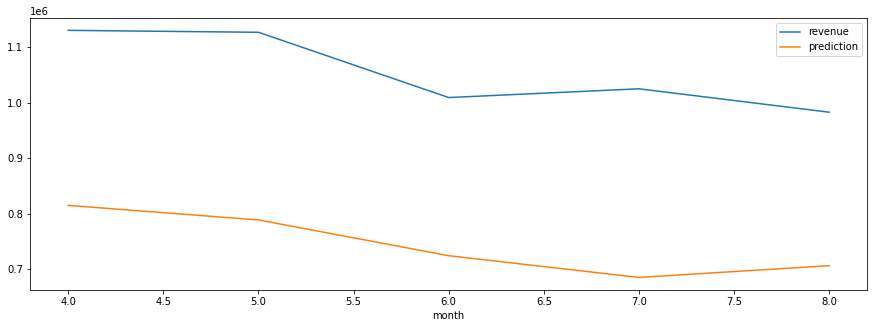

In [28]:
rf_evaluation = pd.concat([df_evaluate.loc[mask]['order_purchase_timestamp'],  np.expm1(y_test)], axis=1)
rf_evaluation = pd.concat([rf_evaluation.reset_index(drop=True), pd.Series(np.expm1(rf_predictions), name='prediction')], axis=1)
rf_evaluation['purchase_date'] = rf_evaluation['order_purchase_timestamp'].dt.date
rf_evaluation['month'] = rf_evaluation['order_purchase_timestamp'].dt.month
rf_evaluation.groupby('month').sum().plot(figsize=(15,5));

In [29]:
evaluation(rf_evaluation.groupby('month').sum()['revenue'], rf_evaluation.groupby('month').sum()['prediction'])

On average, our predictions are 29.49% above or below the real value.
Which means an error of about R$ 310956.35


(310956.35, 29.49166086778567)

#### 2.1.3 LinearRegression

**Individual Prices**

1st cycle:

    On average, our predictions are 72.84% above or below the real value.
    Which means an error of about R$ 85.92
    
2nd cycle:

    On average, our predictions are 72.72% above or below the real value.
    Which means an error of about R$ 85.91

In [23]:
lr = LinearRegression()
lr.fit(x_train, y_train)

lr_predictions = lr.predict(x_test)
evaluation(np.expm1(y_test), np.expm1(lr_predictions))

On average, our predictions are 72.72% above or below the real value.
Which means an error of about R$ 85.91


(85.91, 72.71560993743383)

<AxesSubplot:xlabel='month'>

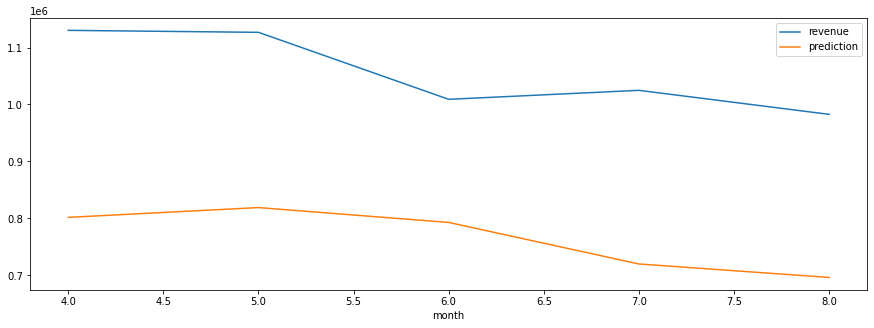

In [24]:
lr_evaluation = pd.concat([df_evaluate.loc[mask]['order_purchase_timestamp'], np.expm1(y_test)], axis=1)
lr_evaluation = pd.concat([lr_evaluation.reset_index(drop=True), pd.Series(np.expm1(lr_predictions), name='prediction')], axis=1)
lr_evaluation['purchase_date'] = lr_evaluation['order_purchase_timestamp'].dt.date
lr_evaluation['month'] = lr_evaluation['order_purchase_timestamp'].dt.month
lr_evaluation.groupby('month').sum().plot(figsize=(15,5))

In [25]:
evaluation(lr_evaluation.groupby('month').sum()['revenue'], lr_evaluation.groupby('month').sum()['prediction'])

On average, our predictions are 27.33% above or below the real value.
Which means an error of about R$ 288617.05


(288617.05, 27.329323828830844)

## 3.0 Features Importances

#### 3.1 Random Forest Importance

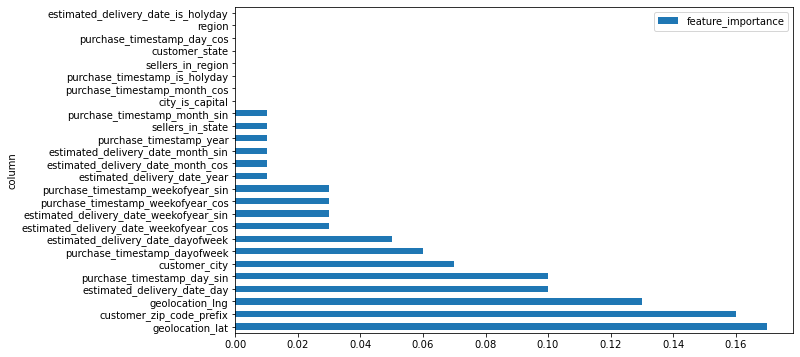

In [30]:
feature_importance = pd.concat([pd.Series(rf.feature_importances_, name='feature_importance'), pd.Series(x_train.columns, name='column')], axis=1)
feature_importance.round(2).sort_values('feature_importance', ascending=False).plot(kind='barh', x='column', figsize=(10,6));

##### 3.2 Linear Regression Importance

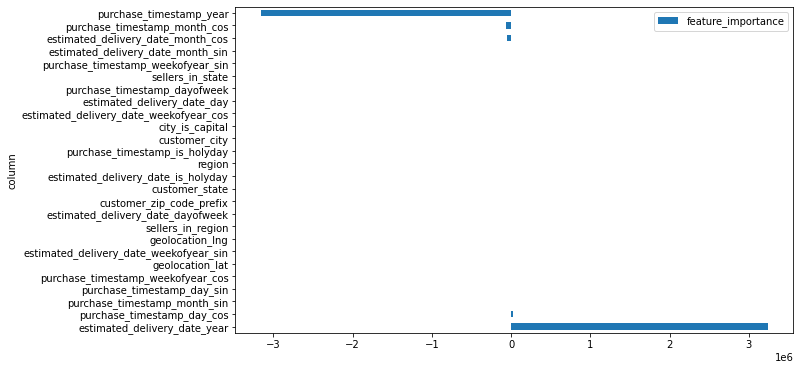

In [31]:
feature_importance = pd.concat([pd.Series(lr.coef_, name='feature_importance'), pd.Series(x_train.columns, name='column')], axis=1)
feature_importance.round(2).sort_values('feature_importance', ascending=False).plot(kind='barh', x='column', figsize=(10,6));

In [42]:
# x_train.select_dtypes(exclude=['bool']).hist(figsize=(15,15));